In [1]:
import gymnasium as gym
import numpy as np
import random
import cv2
import os
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from tqdm import trange
import matplotlib.pyplot as plt
import pandas as pd
import ale_py
import imageio

In [2]:
# Register ALE environments (Crucial for Galaxian to be found)
gym.register_envs(ale_py)

# --- Hyperparameters ---
# Galaxian often requires a slightly lower learning rate than simpler games
# because the diving enemies create high-variance reward spikes.
GAMMA = 0.99                # Discount factor: How much we care about future rewards
LR = 1.0e-4                 # Learning Rate
CLIP_EPS = 0.1              # PPO Clipping range (prevents drastic policy changes)
BATCH_SIZE = 32             # Mini-batch size for SGD
UPDATE_EPOCHS = 4           # How many times to reuse data for training
ENTROPY_COEF = 0.01         # Encourages exploration (prevents getting stuck moving left/right)
VF_COEF = 0.5               # Weight of Value Function loss
MAX_GRAD_NORM = 0.5         # Gradient clipping to prevent exploding gradients
ROLLOUT_STEPS = 500       # Number of steps to play before updating
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "ppo_galaxian.pth"

In [3]:
def preprocess(frame):
    """
    Converts raw Atari RGB frames to 210x160 Grayscale (Matching Implementation A).
    Returns: (210, 160) float array [0, 1]
    """
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    # cv2.resize expects (Width, Height), so we pass (160, 210)
    frame = cv2.resize(frame, (160, 210))
    return frame / 255.0

In [4]:
class FrameStack:
    """
    Stacks 'k' consecutive frames to give the agent a sense of motion.
    
    Galaxian Difference:
    This is CRITICAL for Galaxian. Unlike Space Invaders where movement is grid-like,
    Galaxian enemies 'dive' in curves. A single frame gives no information about
    velocity or dive angle. 4 stacked frames reveal the trajectory.
    """
    def __init__(self, k):
        self.k = k
        self.frames = deque([], maxlen=k)

    def reset(self, frame):
        processed = preprocess(frame)
        # On reset, we duplicate the first frame k times because we have no history
        for _ in range(self.k):
            self.frames.append(processed)
        return np.stack(self.frames, axis=0)

    def step(self, frame):
        processed = preprocess(frame)
        self.frames.append(processed)
        return np.stack(self.frames, axis=0)

In [5]:
class VectorFrameStack:
    """
    Stacks 'k' frames for VECTORIZED environments (Num_Envs > 1).
    Used during GIF generation to handle 16 parallel envs.
    """
    def __init__(self, num_envs, k):
        self.num_envs = num_envs
        self.k = k
        # Create a deque for each environment
        self.frames = [deque([], maxlen=k) for _ in range(num_envs)]

    def reset(self, obs):
        # obs shape: (num_envs, 210, 160, 3)
        processed = [preprocess(o) for o in obs] # List of (84, 84) arrays
        
        stacked_states = []
        for i in range(self.num_envs):
            # Fill deque with duplicates on reset
            for _ in range(self.k):
                self.frames[i].append(processed[i])
            stacked_states.append(np.stack(self.frames[i], axis=0))
            
        return np.array(stacked_states) # Shape: (num_envs, k, 84, 84)

    def step(self, obs):
        processed = [preprocess(o) for o in obs]
        
        stacked_states = []
        for i in range(self.num_envs):
            self.frames[i].append(processed[i])
            stacked_states.append(np.stack(self.frames[i], axis=0))
            
        return np.array(stacked_states)

In [6]:
# --- Actor-Critic Network ---
class ActorCritic(nn.Module):
    def __init__(self, input_shape, n_actions):
        super().__init__()
        # 5-Layer Architecture matching Implementation A
        # Input: (4, 210, 160)
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 8, kernel_size=8, stride=4), nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=4, stride=2), nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2), nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2), nn.ReLU(),
            nn.Flatten()
        )
        
        # Calculate Flatten Size for 210x160 input:
        # L1: 51x39 -> L2: 24x18 -> L3: 11x8 -> L4: 5x3 -> L5: 2x1
        # Flatten: 128 * 2 * 1 = 256
        
        self.fc = nn.Sequential(nn.Linear(256, 256), nn.ReLU())
        self.actor = nn.Linear(256, n_actions)
        self.critic = nn.Linear(256, 1)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            nn.init.orthogonal_(module.weight, gain=np.sqrt(2))
            module.bias.data.fill_(0.0)
            
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return self.actor(x), self.critic(x)

In [7]:
# --- Rollout Buffer ---
class RolloutBuffer:
    def __init__(self):
        self.clear()

    def add(self, state, action, logprob, reward, done, value):
        self.states.append(state)
        self.actions.append(action)
        self.logprobs.append(logprob)
        self.rewards.append(reward)
        self.dones.append(done)
        self.values.append(value)

    def compute_returns_and_advantages(self, last_value, gamma=GAMMA, lam=0.95):
        """
        Generalized Advantage Estimation (GAE).
        Calculates how much better an action was compared to the baseline (Critic's guess).
        """
        values = self.values + [last_value]
        gae = 0
        returns = []
        advantages = []
        
        # Iterate backwards to calculate discounted returns
        for t in reversed(range(len(self.rewards))):
            # Temporal Difference (TD) Error:
            # Reward + Value of Next State - Value of Current State
            delta = self.rewards[t] + gamma * values[t + 1] * (1 - self.dones[t]) - values[t]
            
            # GAE formula (smoothes out the variance)
            gae = delta + gamma * lam * (1 - self.dones[t]) * gae
            
            advantages.insert(0, gae)
            # Return = Advantage + Value (Standard RL identity)
            returns.insert(0, gae + values[t])
            
        self.returns = returns
        self.advantages = advantages

    def get(self):
        # Convert lists to PyTorch tensors and move to GPU/CPU
        return map(lambda x: torch.tensor(np.array(x), dtype=torch.float32).to(DEVICE), 
                   [self.states, self.actions, self.logprobs, self.returns, self.advantages])

    def clear(self):
        self.states, self.actions, self.logprobs = [], [], []
        self.rewards, self.dones, self.values = [], [], []


In [8]:
# --- Action Selection ---
def select_action(model, state):
    # Add batch dimension: (4, 84, 84) -> (1, 4, 84, 84)
    state_t = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(DEVICE)
    
    with torch.no_grad(): # No need to track gradients during rollout
        logits, value = model(state_t)
        
    dist = torch.distributions.Categorical(logits=logits)
    action = dist.sample()
    
    return action.item(), dist.log_prob(action).item(), value.item()

In [9]:
# --- GIF Generation (Vectorized) ---
def generate_gif(model, env_name="ALE/Galaxian-v5", steps=1024, filename="ppo_galaxian.gif"):
    print(f"\nGenerating GIF ({steps} steps)...")
    
    # 1. Setup Environment (Vector mode as requested)
    num_envs = 16
    env = gym.make_vec(env_name, frameskip=4, num_envs=num_envs, vectorization_mode='sync')
    
    # 2. Setup Vector Frame Stacking
    # The model expects 4 stacked frames, but make_vec returns raw frames.
    # We use a helper to maintain stacks for all 16 envs.
    vec_stack = VectorFrameStack(num_envs, k=4)
    
    obs, info = env.reset()
    state = vec_stack.reset(obs) # (16, 4, 84, 84)
    
    # Buffer to store RAW frames for GIF (Steps, Envs, H, W, C)
    obs_buf = np.zeros((steps, num_envs, 210, 160, 3), dtype=np.uint8)
    
    model.eval()
    
    for step in range(steps):
        # Store current raw observation for GIF
        obs_buf[step] = obs
        
        # Prepare state for Model: (16, 4, 84, 84) -> Tensor
        state_t = torch.tensor(state, dtype=torch.float32).to(DEVICE)
        
        # Select Action (Deterministic/Greedy is usually better for visualization, 
        # but we'll sample to match standard PPO inference)
        with torch.no_grad():
            logits, _ = model(state_t)
            dist = torch.distributions.Categorical(logits=logits)
            actions = dist.sample()
            
        # Step environment
        nxt_obs, reward, terminated, truncated, _ = env.step(actions.cpu().numpy())
        
        # Update stack
        state = vec_stack.step(nxt_obs)
        obs = nxt_obs

    # 3. Save GIF
    # Take all steps, 0th environment
    to_render = obs_buf[:, 0, ...] 
    imageio.mimsave(filename, to_render, fps=30, loop=0)
    print(f"Saved '{filename}' successfully.")
    env.close()

In [10]:
# --- Main Training Loop ---
def train_ppo(env_name="ALE/Galaxian-v5", episodes=100):
    print(f"Initializing PPO for {env_name}...")
    env = gym.make(env_name)
    n_actions = env.action_space.n
    print(f"Action Space: {n_actions}")

    frame_stack = FrameStack(4)
    # Update input shape to (4, 210, 160) to match the new preprocessing
    model = ActorCritic((4, 210, 160), n_actions).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LR)

    log_data = []
    best_reward = float('-inf')
    buffer = RolloutBuffer()

    progress_bar = trange(episodes, desc="Training", unit="ep")

    for episode in progress_bar:
        raw_state, _ = env.reset()
        state = frame_stack.reset(raw_state)
        total_reward = 0
        done = False
        buffer.clear()

        # Data Collection (500 steps)
        for _ in range(ROLLOUT_STEPS):
            action, logprob, value = select_action(model, state)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = frame_stack.step(obs)
            
            clipped_reward = np.sign(reward)
            buffer.add(state, action, logprob, clipped_reward, done, value)
            
            state = frame_stack.reset(env.reset()[0]) if done else next_state
            total_reward += reward

            if done:
                raw_state, _ = env.reset()
                state = frame_stack.reset(raw_state)

        # Update
        _, _, last_val = select_action(model, state)
        buffer.compute_returns_and_advantages(last_val)
        states, actions, logprobs_old, returns, advantages = buffer.get()
        actions = actions.long()
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        for _ in range(UPDATE_EPOCHS):
            idx = np.random.permutation(len(states))
            for start in range(0, len(states), BATCH_SIZE):
                batch_idx = idx[start:start + BATCH_SIZE]
                logits, values = model(states[batch_idx])
                dist = torch.distributions.Categorical(logits=logits)
                new_logprobs = dist.log_prob(actions[batch_idx])
                entropy = dist.entropy().mean()
                ratio = (new_logprobs - logprobs_old[batch_idx]).exp()
                surr1 = ratio * advantages[batch_idx]
                surr2 = torch.clamp(ratio, 1 - CLIP_EPS, 1 + CLIP_EPS) * advantages[batch_idx]
                actor_loss = -torch.min(surr1, surr2).mean()
                critic_loss = nn.MSELoss()(values.squeeze(), returns[batch_idx])
                loss = actor_loss + VF_COEF * critic_loss - ENTROPY_COEF * entropy

                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
                optimizer.step()

        log_data.append({"episode": episode, "total_reward": total_reward})
        progress_bar.set_postfix(reward=total_reward)

        if total_reward > best_reward:
            best_reward = total_reward
            torch.save(model.state_dict(), MODEL_PATH)

    env.close()
    
    # Save logs
    df = pd.DataFrame(log_data)
    df.to_csv("ppo_galaxian_log.csv", index=False)
    print("\nTraining complete. Log saved.")
    
    # --- Generate GIF after training ---
    generate_gif(model, env_name, steps=1024)

In [11]:
train_ppo(episodes=100)

Initializing PPO for ALE/Galaxian-v5...
Action Space: 6


A.L.E: Arcade Learning Environment (version 0.10.2+c9d4b19)
[Powered by Stella]
Training: 100%|██████████| 100/100 [03:39<00:00,  2.19s/ep, reward=660]



Training complete. Log saved.

Generating GIF (1024 steps)...
Saved 'ppo_galaxian.gif' successfully.


In [12]:
env_name = "ALE/Galaxian-v5"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make(env_name)
final_model = ActorCritic(input_shape=(4, 84, 84), n_actions=env.action_space.n).to(device)

# 3. Load the Weights
model_path = "ppo_galaxian.pth"
if os.path.exists(model_path):
    state_dict = torch.load(model_path, map_location=device)
    final_model.load_state_dict(state_dict)
    print("Model loaded successfully.")
else:
    print(f"Error: Model file '{model_path}' not found.")

# 4. Set to Eval Mode
final_model.eval()

Model loaded successfully.


ActorCritic(
  (conv): Sequential(
    (0): Conv2d(4, 8, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (7): ReLU()
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (9): ReLU()
    (10): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
  )
  (actor): Linear(in_features=256, out_features=6, bias=True)
  (critic): Linear(in_features=256, out_features=1, bias=True)
)

In [13]:
generate_gif(final_model, env_name="ALE/Galaxian-v5", steps=500, filename="ppo_galaxian_final.gif")


Generating GIF (500 steps)...
Saved 'ppo_galaxian_final.gif' successfully.


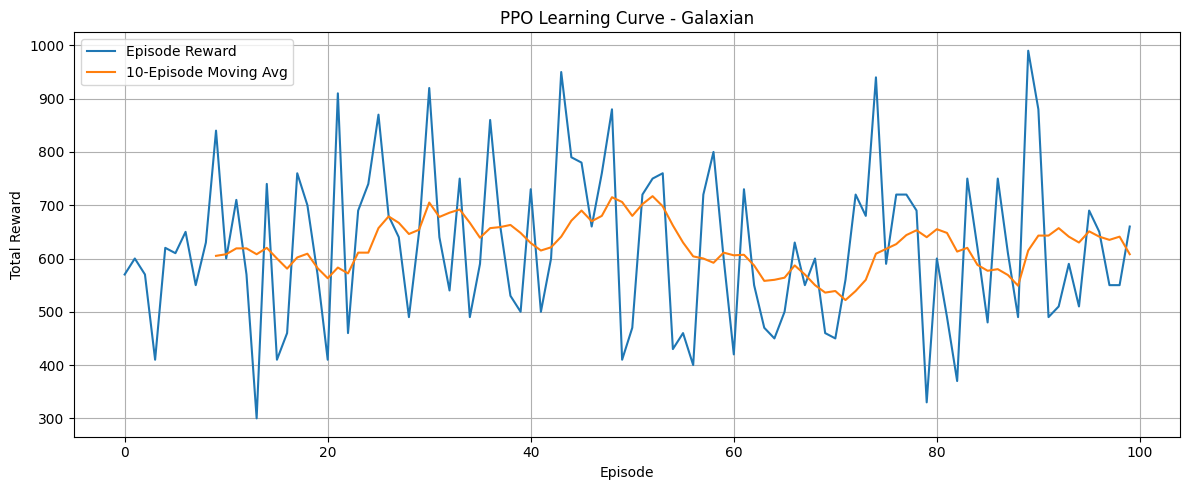

In [14]:
log_df = pd.read_csv("ppo_galaxian_log.csv")

plt.figure(figsize=(12, 5))
plt.plot(log_df["episode"], log_df["total_reward"], label="Episode Reward")

# Moving average
window = 10
moving_avg = log_df["total_reward"].rolling(window).mean()
plt.plot(log_df["episode"], moving_avg, label=f"{window}-Episode Moving Avg")

plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("PPO Learning Curve - Galaxian")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("ppo_rewards_plot.png")
plt.show()
